# Image classification for vehicle body type

### Summary

The goal is to recognize a body type for a vehicle in order to infer a CO2 emission


## Libraries

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
from PIL import Image
sys.modules['Image'] = Image 

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# due to error : failed to initialize cudnn
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka
import tensorflow_addons as tfa

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  

# Data visualization
from matplotlib import pyplot as plt

from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

GPU


Using TensorFlow backend.


## Paths and Constants

In [2]:
# Data paths
path_root = "../../data"
path_data = path_root + '/vehicle_images' # data path
path_data_train = path_data + '/train'
path_data_val = path_data + '/val'

# Saved objects path
path_pretrained_weights_data = path_root + "/pretrained_weights"
path_pretrained_features = path_root + "/pretrained_features"

path_assembled_weights = path_pretrained_weights_data + '/assembled_model_weights'
path_top_model_weights = path_pretrained_weights_data + '/top_model_weights'


car_body_types = ['berline', 'break', 'cabriolet', 'combispace', 'coupe', 'minibus', 'minispace', 'monospace', 'monospace compact', 'tous-terrains']

# Image caracteristics
img_width = 150
img_height = 150
IMG_SHAPE = (img_width, img_height, 3)

# training parameter
base_model_class = ka.InceptionResNetV2
optimizer = "adagrad"
lr = 0.01
loss = 'categorical_crossentropy'
activation_out = "softmax"
batch_size = 1
epochs = 5

## Functions used

In [3]:
def get_top_model(input_shape, activation="softmax", load_weights=None):
    top_model = km.Sequential()
    top_model.add(kl.Flatten(input_shape=input_shape[1:]))
    top_model.add(kl.Dense(img_width, activation='relu'))
    top_model.add(kl.Dropout(0.5))
    top_model.add(kl.Dense(len(car_body_types), activation=activation))
    
    if load_weights:
        top_model.load_weights(path_top_model_weights)
    
    return top_model

In [4]:
def get_base_model(m=ka.ResNet50V2, input_shape=IMG_SHAPE):
    base_model = m(input_shape=input_shape, include_top=False, weights='imagenet')
    return base_model

In [14]:
def get_assembled_model(load_weights=False, load_weights_top_model=True):
    base_model = get_base_model(base_model_class)
    
    for layer in base_model.layers[:-1]:
        layer.trainable =  False
    
    # get the output dimension for the base_model prediction
    img_rdn = np.random.random(IMG_SHAPE)
#     img_rdn = np.expand_dims(img_rdn, axis=0) # ajout d'une nouvelle dimension avec un 1
    img_rdn = img_rdn[np.newaxis,:,:,:] # ajout d'une nouvelle dimension avec un None
    dim = base_model.predict(img_rdn).shape
    
    print("\n\n##################################")
    print("modèle utilisé : ", base_model.name)
    print("##################################\n\n")
    
    top_model = get_top_model(dim, load_weights=load_weights_top_model)
    for layer in top_model.layers[:-1]:
        layer.trainable =  False

    assembled_model = km.Model(inputs=base_model.input, \
                               outputs=top_model(base_model.output), \
                               name=base_model.name + "-fine-tuned")
    if load_weights:
        assembled_model.load_weights(path_assembled_weights)

    return assembled_model

In [6]:
def get_generators(class_mode_train=None,class_mode_val=None, shuffle=False):
    # We will now send our data to the loaded model in order to build our features.
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)

    gen_train = datagen.flow_from_directory(
            path_data_train,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=class_mode_train,  # this means our generator will only yield batches of data, no labels
            shuffle=shuffle)  

    gen_val = datagen.flow_from_directory(
            path_data_val,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=class_mode_val,
            shuffle=shuffle)
    return gen_train, gen_val

In [7]:
def get_train_val_labels(generator_train, generator_val):
    num_classes = len(generator_train.class_indices)
    train_labels = generator_train.classes
    train_labels = to_categorical(train_labels, num_classes=num_classes)  

    num_classes = len(generator_val.class_indices)
    val_labels = generator_val.classes
    val_labels = to_categorical(val_labels, num_classes=num_classes)
    
    return train_labels, val_labels

In [8]:
def get_features_train_val(base_model):
    gen_train, gen_val = get_generators()
    features_train = base_model.predict_generator(gen_train, len(gen_train.filenames) / batch_size,  verbose = 1)
    features_validation = base_model.predict_generator(gen_val, len(gen_val.filenames) / batch_size,  verbose = 1)  
    return features_train, features_validation

In [9]:
def plot_training(history):
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

    # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()

In [10]:
def evaluation(model, features_train, train_labels, features_validation, validation_labels):
    ts = time.time()
    score_train = model.evaluate(features_train, train_labels)
    score_val = model.evaluate(features_validation, validation_labels)
    te = time.time()
    t_prediction_fcm = te-ts
    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_val[1])
    print("Time Prediction: %.2f seconds" %t_prediction_fcm)
    
    return score_train[1], score_val[1], t_prediction_fcm

## Features generation with base model

In [12]:
# We will now send our data to the loaded model in order to build our features.
features_train, features_validation = get_features_train_val(get_base_model(base_model_class))
nb_train_samples, nb_validation_samples = len(features_train), len(features_validation)

Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
439/439 [==============================] - 21s 49ms/step


In [13]:
# We save the features for training and validation
np.save(path_pretrained_features + '/bottleneck_features_train.npy', features_train)  
np.save(path_pretrained_features + '/bottleneck_features_val.npy', features_validation)  

## Train the top model before assembling

In order to train the top model, we need the class labels for each of the training/validation samples. We use a data generator for that also. We also need to convert the labels to categorical vectors.

In [14]:
def train_top_model(save_weights=True,optimizer="adam", loss='categorical_crossentropy', epochs=3):
    generator_top_train, generator_top_val = get_generators(class_mode_train='categorical')
    train_labels, val_labels = get_train_val_labels(generator_top_train, generator_top_val)

    nb_train_samples = len(generator_top_train.filenames)  
    nb_val_samples = len(generator_top_val.filenames)  

    train_data = np.load(path_pretrained_features + '/bottleneck_features_train.npy')  
    validation_data = np.load(path_pretrained_features + '/bottleneck_features_val.npy')  

    # Now create and train a small fully-connected network - the top model - using the bottleneck features as input, with our classes as the classifier output.
    top_model = get_top_model(train_data.shape)
    top_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=['accuracy'])
    history = top_model.fit(train_data, train_labels,  
              epochs=epochs,  
              batch_size=batch_size,  
              validation_data=(validation_data, val_labels))
    
    if save_weights:
        top_model.save_weights(path_top_model_weights)

    # evaluation
    (eval_loss, eval_accuracy) = top_model.evaluate(  
         validation_data, val_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
    print("[INFO] Loss: {}".format(eval_loss))  
    
    plt.figure(1)  
    
    return history

### Loss function comparisons

##################################################
optimizer :  <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
loss :  mean_squared_error
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 0.0923 - accuracy: 0.1201 - val_loss: 0.0893 - val_accuracy: 0.1549
Epoch 2/3
1407/1407 [==============================] - 3s 2ms/sample - loss: 0.0892 - accuracy: 0.1585 - val_loss: 0.0885 - val_accuracy: 0.1800
Epoch 3/3
439/439 [==============================] - 0s 1ms/sample - loss: 0.0879 - accuracy: 0.2187
[INFO] accuracy: 21.87%
[INFO] Loss: 0.08794497620475591


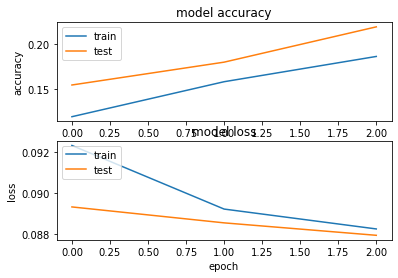

##################################################
optimizer :  <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
loss :  categorical_hinge
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.0218 - accuracy: 0.1052 - val_loss: 1.0012 - val_accuracy: 0.1093
Epoch 2/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.0007 - accuracy: 0.0981 - val_loss: 1.0005 - val_accuracy: 0.1071
Epoch 3/3
439/439 [==============================] - 0s 1ms/sample - loss: 1.0004 - accuracy: 0.1048
[INFO] accuracy: 10.48%
[INFO] Loss: 1.0003646283595058


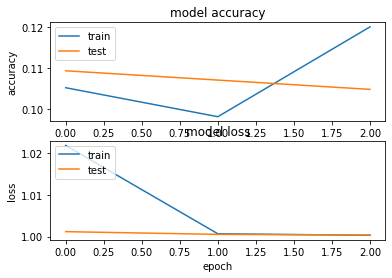

##################################################
optimizer :  <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 2.2961 - accuracy: 0.1670 - val_loss: 2.1355 - val_accuracy: 0.2620
Epoch 2/3
1407/1407 [==============================] - 3s 2ms/sample - loss: 2.0255 - accuracy: 0.2886 - val_loss: 2.0219 - val_accuracy: 0.3144
Epoch 3/3
439/439 [==============================] - 0s 1ms/sample - loss: 1.9599 - accuracy: 0.3394
[INFO] accuracy: 33.94%
[INFO] Loss: 1.9598954575208434


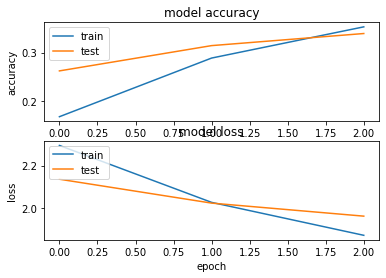

In [17]:
loss_fcts = ["mean_squared_error", "categorical_hinge", "categorical_crossentropy"]
histories = []

for loss_fct in loss_fcts:
    print("##################################################")
    print("optimizer : ", optimizer)
    print("loss : ", loss_fct)
    print("##################################################")
    history = train_top_model(save_weights=False, loss=loss_fct, optimizer=optimizer)
    plot_training(history)
    histories.append(history)

The loss function "categorical_crossentropy" gives the best results (36%%) while "mean_squared_error" gives 32%" and "categorical_hinge" gives 24% and 

### Optimizers comparisons

##################################################
optimizer :  adam
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 5s 3ms/sample - loss: 4.2651 - accuracy: 0.1329 - val_loss: 2.1645 - val_accuracy: 0.2096
Epoch 2/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 2.2914 - accuracy: 0.1002 - val_loss: 2.2993 - val_accuracy: 0.1116
Epoch 3/3
439/439 [==============================] - 1s 2ms/sample - loss: 2.2694 - accuracy: 0.1298
[INFO] accuracy: 12.98%
[INFO] Loss: 2.269391261363627


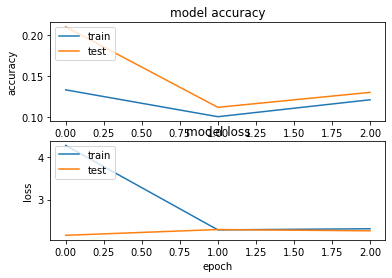

##################################################
optimizer :  adamax
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 5s 3ms/sample - loss: 3.1171 - accuracy: 0.2075 - val_loss: 2.0732 - val_accuracy: 0.2528
Epoch 2/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 2.1074 - accuracy: 0.2395 - val_loss: 2.0452 - val_accuracy: 0.2733
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 1.9827 - accuracy: 0.3189
[INFO] accuracy: 31.89%
[INFO] Loss: 1.982651731411909


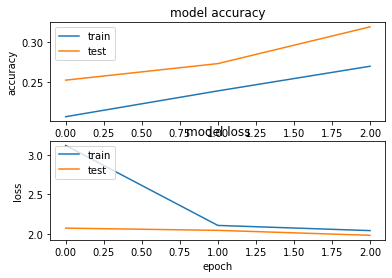

##################################################
optimizer :  adagrad
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 5s 3ms/sample - loss: 2.5999 - accuracy: 0.2395 - val_loss: 1.8411 - val_accuracy: 0.3508
Epoch 2/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.9211 - accuracy: 0.3269 - val_loss: 1.7880 - val_accuracy: 0.3736
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 1.7662 - accuracy: 0.3895
[INFO] accuracy: 38.95%
[INFO] Loss: 1.7662217579169437


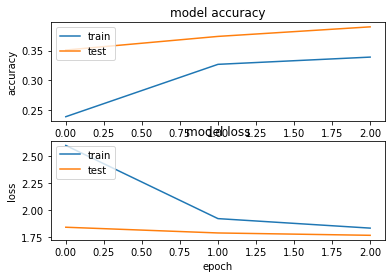

##################################################
optimizer :  adadelta
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 5s 4ms/sample - loss: 4.2780 - accuracy: 0.0974 - val_loss: 2.8055 - val_accuracy: 0.1276
Epoch 2/3
1407/1407 [==============================] - 5s 3ms/sample - loss: 3.3438 - accuracy: 0.1166 - val_loss: 2.4936 - val_accuracy: 0.1617
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 2.3432 - accuracy: 0.2073
[INFO] accuracy: 20.73%
[INFO] Loss: 2.3431530020503084


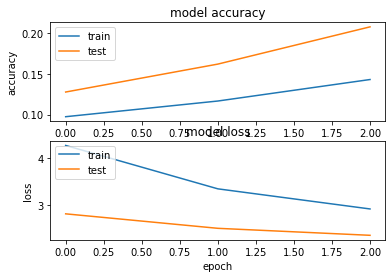

##################################################
optimizer :  sgd
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 11.0222 - accuracy: 0.0967 - val_loss: 2.3001 - val_accuracy: 0.1071
Epoch 2/3
1407/1407 [==============================] - 4s 3ms/sample - loss: 2.3138 - accuracy: 0.0910 - val_loss: 2.2985 - val_accuracy: 0.1116
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 2.2982 - accuracy: 0.1116
[INFO] accuracy: 11.16%
[INFO] Loss: 2.2982082931761862


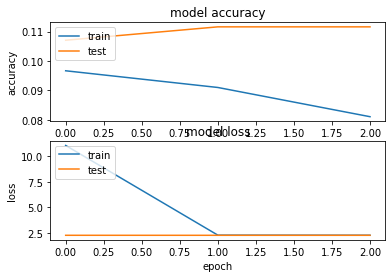

##################################################
optimizer :  rmsprop
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 6s 5ms/sample - loss: 4.2937 - accuracy: 0.1713 - val_loss: 2.0933 - val_accuracy: 0.2620
Epoch 2/3
1407/1407 [==============================] - 6s 4ms/sample - loss: 2.3494 - accuracy: 0.1947 - val_loss: 2.1380 - val_accuracy: 0.2847
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 2.1344 - accuracy: 0.2893
[INFO] accuracy: 28.93%
[INFO] Loss: 2.1344388347538406


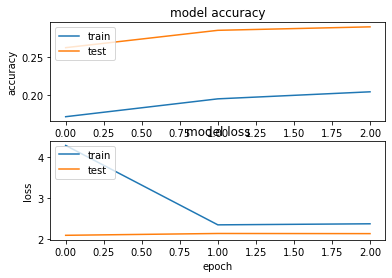

##################################################
optimizer :  nadam
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/3
1407/1407 [==============================] - 10s 7ms/sample - loss: 3.2145 - accuracy: 0.0931 - val_loss: 2.3000 - val_accuracy: 0.1071
Epoch 2/3
1407/1407 [==============================] - 9s 7ms/sample - loss: 2.3512 - accuracy: 0.1009 - val_loss: 2.2980 - val_accuracy: 0.1139
Epoch 3/3
439/439 [==============================] - 1s 1ms/sample - loss: 2.2980 - accuracy: 0.1139
[INFO] accuracy: 11.39%
[INFO] Loss: 2.297955617274673


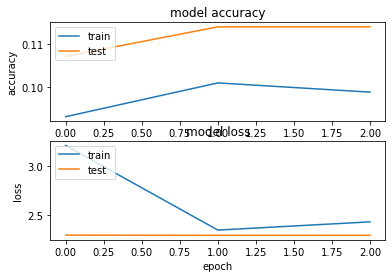

In [15]:
optimizers = ["adam", "adamax", "adagrad", "adadelta", "sgd", "rmsprop", "nadam"]
histories = []

for opt in optimizers:
    print("##################################################")
    print("optimizer : ", opt)
    print("loss : ", loss)
    print("##################################################")
    history = train_top_model(save_weights=False, loss=loss, optimizer=opt)
    plot_training(history)
    histories.append(history)

We can see high disparities of optimizer efficiencies for our problem. adamax (36%) is the best with adagrad (36%) followed by rmsprop(26%). The others are under 20% 

### Train & save top model weights

In [21]:
print("##################################################")
print("optimizer : ", optimizer)
print("loss : ", loss)
print("##################################################")
history = train_top_model(save_weights=True, loss=loss, optimizer=optimizer, epochs=20)

##################################################
optimizer :  adagrad
loss :  categorical_crossentropy
##################################################
Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.
Train on 1407 samples, validate on 439 samples
Epoch 1/20
1407/1407 [==============================] - 4s 3ms/sample - loss: 2.4437 - accuracy: 0.2239 - val_loss: 1.9103 - val_accuracy: 0.3280
Epoch 2/20
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.9528 - accuracy: 0.2914 - val_loss: 1.8468 - val_accuracy: 0.3371
Epoch 3/20
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.8662 - accuracy: 0.3305 - val_loss: 1.7902 - val_accuracy: 0.3827
Epoch 4/20
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.7518 - accuracy: 0.3468 - val_loss: 1.7328 - val_accuracy: 0.3827
Epoch 5/20
1407/1407 [==============================] - 4s 3ms/sample - loss: 1.6997 - accuracy: 0.3795 - val_loss: 1.7674 - val

<Figure size 432x288 with 0 Axes>

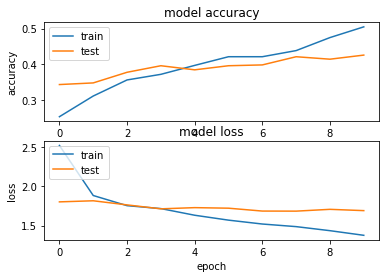

In [20]:
plot_training(history)

### Fine tuning

In [11]:
def train_assembled_model(save_weights=True, optimizer="adam" ,loss='categorical_crossentropy', epochs=5):
    generator_train, generator_val = get_generators(class_mode_train="categorical", class_mode_val="categorical")

    train_labels, val_labels = get_train_val_labels(generator_train, generator_val)
    nb_train_samples = len(generator_train.filenames)  
    nb_val_samples = len(generator_val.filenames)  
    
    model = get_assembled_model()
    model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=['accuracy'])


    # training
    history = model.fit_generator(generator=generator_train,
                         epochs=epochs,
                         steps_per_epoch=nb_train_samples // (batch_size * epochs),
                         validation_steps=int(nb_val_samples // batch_size),
                         validation_data=generator_val)
    
    if save_weights:
        model.save_weights(path_assembled_weights)
    
    return history

In [17]:
history = None

with tf.device("/gpu:0"):
    history = train_assembled_model(save_weights=True, optimizer=ko.Adagrad(learning_rate=lr), loss=loss, epochs=10)

Found 1407 images belonging to 10 classes.
Found 439 images belonging to 10 classes.


##################################
modèle utilisé :  inception_resnet_v2
##################################


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 140 steps, validate for 439 steps
Epoch 1/10
140/140 [==============================] - 47s 333ms/step - loss: 2.5215 - accuracy: 0.0929 - val_loss: 1.6292 - val_accuracy: 0.4624
Epoch 2/10
140/140 [==============================] - 34s 241ms/step - loss: 2.3551 - accuracy: 0.1500 - val_loss: 1.6286 - val_accuracy: 0.4624
Epoch 3/10
140/140 [==============================] - 34s 245ms/step - loss: 2.3474 - accuracy: 0.1286 - val_loss: 1.6251 - val_accuracy: 0.4579
Epoch 4/10
140/140 [==============================] - 35s 249ms/step - loss: 2.3984 - accuracy: 0.1286 - val_loss: 1.6249 - val_accuracy: 0.4601
Epoch 5/10
140/140 [==============================] - 34s 241ms/step - loss: 2.3969 - accuracy: 0.1500 - val_loss: 1.6292 - val_a

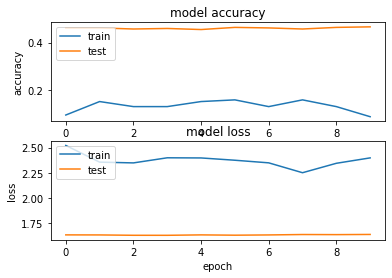

In [18]:
plot_training(history)

# Load model weights

In [19]:
model = get_assembled_model(load_weights=True)



##################################
modèle utilisé :  inception_resnet_v2
##################################




In [26]:
img = kpi.load_img(path_data_train + '/cabriolet/0150.jpg').resize((150,150))
x = kpi.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
y = model.predict(x)
y

array([[0.38852322, 0.00558292, 0.28136775, 0.01407133, 0.1471572 ,
        0.03193379, 0.01218078, 0.06754816, 0.04727053, 0.00436429]],
      dtype=float32)

In [32]:
num_class = np.argmax(y)
class_name = car_body_types[num_class]
class_name

'berline'